### Project Description
This tool can be used to fit EIS data generated from inhomogenous porous eletrodes. 

### Import the needed modules

In [1]:
%matplotlib ipympl
from models import *
# from models import find_index_of_nearest
from impedance.preprocessing import readCSV, readBioLogic
from impedance.visualization import plot_nyquist,plot_bode
from impedance.models.circuits import CustomCircuit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from arbitau import give_z_for_arbitary_tau, tau_plotter
from scipy.integrate import solve_bvp

In [20]:
# profile = mr.Select(value="Uni", 
#                    choices=["Uni", "2Step", "3Step", "Lin", "Ilin", "Abritrary"], 
#                    label="Select Profile")

mercury.Select

## Bring and plot your EIS data here

Please provide your EIS data in a CSV file where the first column should contain the frequency values, second column should contain the real part of the impedance, the third column should contain the imaginary part of the impedance

Please order the data in either ascending or descending order of frequency values

In [10]:
#can provide csv or mpt files, keep the data file in the same folder as this jupyter file
#for example:
#freq_list, zexp = readCSV("./name_of_your_file.csv")

freq_list, zexp = readCSV("./zdata3.csv")

#Below are some examples what type of data can be brought
#freq, zexp = readBioLogic("exampleData.mpt")
#freq, zexp = readCSV("hello.csv")

### Generate Synthetic Exp Data
We can generate synthetic data using any of our four default available profiles,
Or we can even generate the impedance data for any arbitray tortuosity profile given as a function of thickness fraction of electrode (this function should be a continous and differentiable function of x from x=0 to 1)

In [3]:
freq_list=np.logspace(-1,2,100)

##### Arbitary Tortuosity Profile

In [ ]:
fig, ax=plt.subplots()
def tau9(x):
    return 5+np.tanh(x*10-5)+2*np.tanh(x*10-4)
zexp=give_z_for_arbitary_tau(tau9,freq_list,ax,"τ=*")
# print(zexp)

##### Default Tortuosity Profiles

In [8]:
#parameter for the TLM
Q=1e-6
alpha=1

R1=400
delta1=0.3
R2=400
R3=400
delta2=0.3


#initial guesses for the HFR intercept and for any semicircle like features in the EIS data
Rhfr=40
Rrxn=40
Qdl=1e-6
alpha2=1

#For Two-step provide R1,R2,Q,delta1,alpha
#For Three-step provide R1,R2,R3,Q,delta1,delta2,alpha
#For Linear provide R1,R2,Q,alpha
#For Inv-Linear provide R1,R2,Q,alpha

###For arbitary profile provide <what?>###
#write the profile that you want to fit
#tau should remain >=1 in the entire domain of the electrode
#for example, tau=1+np.sin(2*x)

In [23]:
#---uncomment the line below for fitting the uniform tortuosity profile---
#cmodel=CustomCircuit(initial_guess=[R1,Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMuni_1-R_1-p(R_2,CPE_1)")

#cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMtwo_1-R_1-p(R_2,CPE_1)")

cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,R3*Q,delta1,delta2,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMthree_1-R_1-p(R_2,CPE_1)")

# cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMlin_1-R_1-p(R_2,CPE_1)")

# cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMilin_1-R_1-p(R_2,CPE_1)")

In [ ]:
zexp=cmodel.predict(frequencies=freq_list)

### Plot the impedance Data

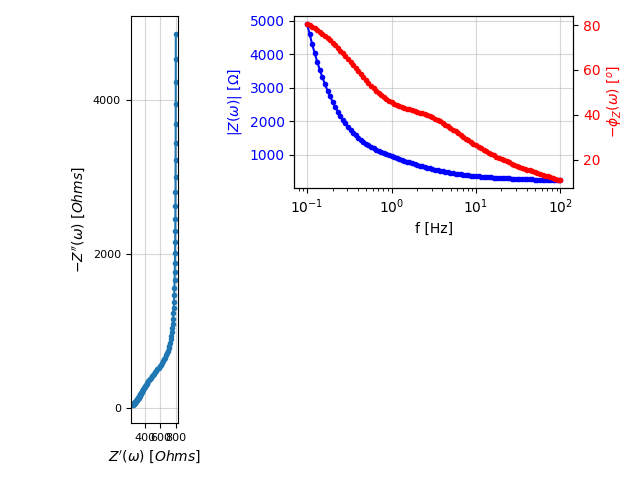

In [11]:
fig= plt.figure()
ax_nyq=fig.add_subplot(121)
ax_mag=fig.add_subplot(222)
ax_phs=ax_mag.twinx()

#plot nyquist plot of the taken data
plot_nyquist(zexp,ax=ax_nyq,labelsize=10,ticksize=8)

#plot bode plot of the taken data
ax_mag.plot(freq_list, np.abs(zexp), '.-', color="blue")
ax_phs.plot(freq_list, -np.angle(zexp, deg=True), '.-',color="red")
ax_mag.set_ylabel(r'$|Z(\omega)|$ ' +'$[{}]$'.format("Ω"), fontsize=10,color="blue")
ax_phs.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=10,color="red")
ax_mag.set_xlabel('f [Hz]', fontsize=10)
ax_mag.set_xscale('log')
ax_mag.tick_params(axis='y', labelcolor="blue")
ax_phs.tick_params(axis='y', labelcolor="red")
ax_mag.grid(visible=True, which='major', axis='both', alpha=.5)
fig.tight_layout()

### Provide the frequency range in which you want to fit

In [12]:
f_high=1e2   #high
f_low=1e-1   #Low

fhigh_idx=find_index_of_nearest(freq_list,f_high)
flow_idx=find_index_of_nearest(freq_list,f_low)
print(fhigh_idx," ",flow_idx)

#crop the data, that falls in this frequency range
if(fhigh_idx<flow_idx):
    freq_to_fit=freq_list[fhigh_idx:flow_idx]
    zexp_to_fit=zexp[fhigh_idx:flow_idx]
else:
    freq_to_fit=freq_list[flow_idx:fhigh_idx]
    zexp_to_fit=zexp[flow_idx:fhigh_idx]


99   0


##### See the data for the freq range that you have choosen

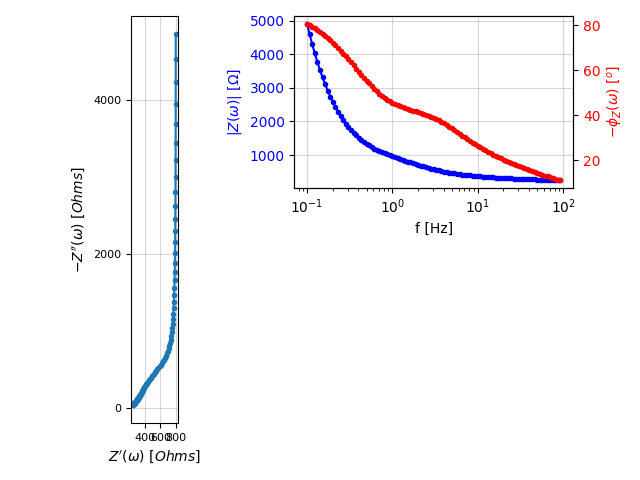

In [13]:
##-----------##
#put the nyquist and the bode plot on the same figure

fig= plt.figure()
ax_nyq=fig.add_subplot(121)
ax_mag=fig.add_subplot(222)
ax_phs=ax_mag.twinx()

#plot nyquist plot of the taken data
plot_nyquist(zexp_to_fit,ax=ax_nyq,labelsize=10,ticksize=8)

#plot bode plot of the taken data
mag_color="blue"
phs_color="red"
ax_mag.plot(freq_to_fit, np.abs(zexp_to_fit), '.-', color=mag_color)
ax_phs.plot(freq_to_fit, -np.angle(zexp_to_fit, deg=True), '.-',color=phs_color)
ax_mag.set_ylabel(r'$|Z(\omega)|$ ' +'$[{}]$'.format("Ω"), fontsize=10,color=mag_color)
ax_phs.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=10,color=phs_color)
ax_mag.set_xlabel('f [Hz]', fontsize=10)
ax_mag.set_xscale('log')
ax_mag.tick_params(axis='y', labelcolor=mag_color)
ax_phs.tick_params(axis='y', labelcolor=phs_color)
ax_mag.grid(visible=True, which='major', axis='both', alpha=.5)
fig.tight_layout()

### Choose the inhomogenity profile of tortuosity and provide the initial guesses for the parameters
The following profiles are available

1. Uniform tortuosity
2. Two-Step inhomogenity in tortuosity
3. Three-Step
4. Linearly varying toruosity
5. Inverse-Linear

Or an arbitary profile for tortuosity can also be provided.


#### Provide Intial guesses for the parameters

In [14]:
#initial guesses for the TLM
#Double layer Capacitance inside porous electrode
Q=6.61e-4
alpha=1

R1=400
delta1=0.3
R2=400

R3=400
delta2=0.3


#initial guesses for the HFR intercept and for any semicircle like features in the EIS data
Rhfr=200
Rrxn=200
Qdl=6.61e-4
alpha2=1

#other (for arbitrary tortuosity profile)
Rref=200
a=4
b=5

#For Two-step provide R1,R2,Q,delta1,alpha
#For Three-step provide R1,R2,R3,Q,delta1,delta2,alpha
#For Linear provide R1,R2,Q,alpha
#For Inv-Linear provide R1,R2,Q,alpha

###For arbitary profile provide <what?>###
#write the profile that you want to fit
#tau should remain >=1 in the entire domain of the electrode
#for example, tau=1+np.sin(2*x)

#### Create the circuit to be fit

In [17]:
#---uncomment the line below for fitting the appropriate tortuosity profile---

#cmodel=CustomCircuit(initial_guess=[R1,Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMuni_1-R_1-p(R_2,CPE_1)")

#cmodel5=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMtwo_1-R_1-p(R_2,CPE_1)")

cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,R3*Q,delta1,delta2,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMthree_1-R_1-p(R_2,CPE_1)")

# cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMlin_1-R_1-p(R_2,CPE_1)")

# cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMilin_1-R_1-p(R_2,CPE_1)")


### Provide an arbitray Tortuosity Profile

In [ ]:
#-- uncomment the line below for fitting an arbitrary tortuosity profile--#

@element(num_params=4,units=["","","",""],overwrite=True)
def arbitau(p,f):
    # modify the number of parameters according to the torutosity function
    Rref, Q, a, b = p[0], p[1], p[2], p[3]
    # provide the definition for the arbitrary tortuosity function
    
    def tau(x):
        # return 5+np.tanh(x*10-3)+2*np.tanh(x*10-5)
        return 5+np.tanh(x*10-a)+2*np.tanh(x*10-b)
    
    def fun(x,y,lmd):
        return np.vstack((y[2]*tau(x),y[3]*tau(x),-lmd*y[1],lmd*y[0]))

    def bc(ya,yb):
        return np.array([ya[0]-1,yb[2],yb[3],ya[1]])

    # Q=6.61e-4
    # Rref=194.56

    x=np.linspace(0,1,1000)
    y=np.zeros((4,x.size))
    # print(y)

    Z_list=np.zeros((np.size(np.array(f))),dtype=complex)
    # print(Z_list)
    ii=0
    for freq in np.array(f):
        w=2*np.pi*freq
        lmd2=w*Q*Rref
        sol1 = solve_bvp(lambda x,y: fun(x,y,lmd=lmd2), bc, x, y)
        y3=sol1.sol(x)[2]
        y4=sol1.sol(x)[3]
        Z=2/(-(1/(Rref))*(y3[0]+y4[0]*1j))
        Z_list[ii]=Z
        ii=ii+1

    return Z_list

@element(num_params=5,units=["","","","",""],overwrite=True)
def arbitaualha(p,f):
    # modify the number of parameters according to the torutosity function
    Rref, Q, alpha, a, b = p[0], p[1], p[2], p[3], p[4]

    #we want to give only R1 and R2 and one two more parameters
    # provide the definition for the arbitrary tortuosity function
    
    def tau(x):
        # return 5+np.tanh(x*10-3)+2*np.tanh(x*10-5)
        return 5+np.tanh(x*10-a)+2*np.tanh(x*10-b)
    
    def fun(x,y,lmdcos,lmdsin):
        return np.vstack((y[2]*tau(x),y[3]*tau(x),lmdcos*y[0]-lmdsin*y[1],lmdcos*y[1]+lmdsin*y[0]))

    def bc(ya,yb):
        return np.array([ya[0]-1,yb[2],yb[3],ya[1]])

    # Q=6.61e-4
    # Rref=194.56

    x=np.linspace(0,1,1000)
    y=np.zeros((4,x.size))
    # print(y)

    Z_list=np.zeros((np.size(np.array(f))),dtype=complex)
    # print(Z_list)
    ii=0
    for freq in np.array(f):
        w=2*np.pi*freq
        lmdcos=w**alpha*Q*Rref*np.cos(alpha*np.pi/2)
        lmdsin=w**alpha*Q*Rref*np.sin(alpha*np.pi/2)
        sol1 = solve_bvp(lambda x,y: fun(x,y,lmdcos=lmdcos,lmdsin=lmdsin), bc, x, y)
        y3=sol1.sol(x)[2]
        y4=sol1.sol(x)[3]
        Z=2/(-(1/(Rref))*(y3[0]+y4[0]*1j))
        Z_list[ii]=Z
        ii=ii+1

    return Z_list

# cmodel=CustomCircuit(initial_guess=[Rref,Q,a,b,Rhfr,Rrxn,Qdl,alpha2],circuit="arbitau_1-R_1-p(R_2,CPE_1)")
cmodel=CustomCircuit(initial_guess=[Rref,Q,a,b],circuit="arbitau_1")
# cmodel1=CustomCircuit(initial_guess=[Rref,Q,1,a,b,Rhfr,Rrxn,Qdl,alpha2],circuit="arbitaualha_1-R_1-p(R_2,CPE_1)")
cmodel1=CustomCircuit(initial_guess=[Rref,Q,1,a,b,Rhfr,Rrxn,Qdl,alpha2],circuit="arbitaualha_1-R_1-p(R_2,CPE_1)")
# cmodel2=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,R3*Q,delta1,delta2,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMthree_1-R_1-p(R_2,CPE_1)")

# print(cmodel)
# zzz=cmodel.predict(frequencies=freq_to_fit)
zzz1=cmodel1.predict(frequencies=freq_to_fit)
# zzz2=cmodel2.predict(frequencies=freq_to_fit)
# print(zzz)
print(zzz1)
# print(zzz2)

### Choose weighing method, the algorithm for the fitting and the bounds on the parameter values

In [19]:
#wt="unit"
wt="mod"
#wt="prop"

def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))
    
#cmodel.fit(impedance=zexp,frequencies=freq,sigma=give_weights(zexp,wt),bounds=[(0,0,0.5,0.5),(np.inf,np.inf,1)])

##Three Step Fitting
cmodel.fit(impedance=zexp,frequencies=freq_list,sigma=give_weights(zexp,wt),bounds=[(0,0,0,0,0,0,0.5,0,0,0,0.5),(np.inf,np.inf,np.inf,np.inf,1,1,1,np.inf,np.inf,np.inf,1)])

#cmodel.fit(impedance=zout,frequencies=f,bounds=[(0,0,0,0,0,0,0.5),(np.inf,np.inf,np.inf,np.inf,1,1,1)])
    
# cmodel5=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMtwo_1-R_1-p(R_2,CPE_1)")
# cmodel1=CustomCircuit(initial_guess=[Rref,Q,1,a,b,Rhfr,Rrxn,Qdl,alpha2],circuit="arbitaualha_1-R_1-p(R_2,CPE_1)")

# cmodel5.fit(impedance=zexp,frequencies=freq_list,bounds=[(0,0,0.5,0,0,0,0,0,0.5),(np.inf,np.inf,1,np.inf,np.inf,np.inf,np.inf,np.inf,1)])
#cmodel.fit(impedance=zout,frequencies=f,bounds=[(0,0,0,0.5),(np.inf,np.inf,np.inf,1)])

# print(give_weights(zexp,wt))
# print(zexp)

# fit the arbitrary profile with a and b as unknowns
# cmodel.fit(impedance=zexp,frequencies=freq_list,sigma=give_weights(zexp,wt),bounds=[(0,0,0,0,0,0,0,0.5),(np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,1)])

#cmodel.fit(impedance=zexp,frequencies=freq_list,bounds=[(0,0,0,0,0,0,0,0.5),(np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,1)])
# cmodel.fit(impedance=zexp,frequencies=freq_list,bounds=[(0,0,0,0),(np.inf,np.inf,np.inf,np.inf)])
# cmodel1.fit(impedance=zexp,frequencies=freq_list,sigma=give_weights(zexp,wt),bounds=[(0,0,0.5,0,0,0,0,0,0.5),(np.inf,np.inf,1,np.inf,np.inf,np.inf,np.inf,np.inf,1)])

# cmodel1.fit(impedance=zexp,frequencies=freq_list,sigma=give_weights(zexp,wt),bounds=[(0,0,0.5,0,0),(np.inf,np.inf,1,np.inf,np.inf)])

### Print The fitted Circuit with values of the fitted parameters

In [20]:
print(cmodel)


Circuit string: TLMthree_1-R_1-p(R_2,CPE_1)
Fit: True

Initial guesses:
  TLMthree_1_0 = 4.00e+02 [Ohm]
  TLMthree_1_1 = 2.64e-01 [Ohm F]
  TLMthree_1_2 = 2.64e-01 [Ohm F]
  TLMthree_1_3 = 2.64e-01 []
  TLMthree_1_4 = 3.00e-01 []
  TLMthree_1_5 = 3.00e-01 []
  TLMthree_1_6 = 1.00e+00 []
    R_1 = 2.00e+02 [Ohm]
    R_2 = 2.00e+02 [Ohm]
  CPE_1_0 = 6.61e-04 [Ohm^-1 sec^a]
  CPE_1_1 = 1.00e+00 []

Fit parameters:
  TLMthree_1_0 = 3.99e+02  (+/- 1.03e+00) [Ohm]
  TLMthree_1_1 = 2.64e-01  (+/- 6.81e-04) [Ohm F]
  TLMthree_1_2 = 4.26e-01  (+/- 6.12e-03) [Ohm F]
  TLMthree_1_3 = 1.03e+00  (+/- 6.57e-03) []
  TLMthree_1_4 = 3.10e-01  (+/- 5.21e-03) []
  TLMthree_1_5 = 1.81e-01  (+/- 1.18e-03) []
  TLMthree_1_6 = 1.00e+00  (+/- 7.99e-05) []
    R_1 = 2.00e+02  (+/- 5.60e-02) [Ohm]
    R_2 = 2.03e+02  (+/- 1.97e+00) [Ohm]
  CPE_1_0 = 6.56e-04  (+/- 8.81e-06) [Ohm^-1 sec^a]
  CPE_1_1 = 9.93e-01  (+/- 2.02e-03) []



### See how the model fits to the data

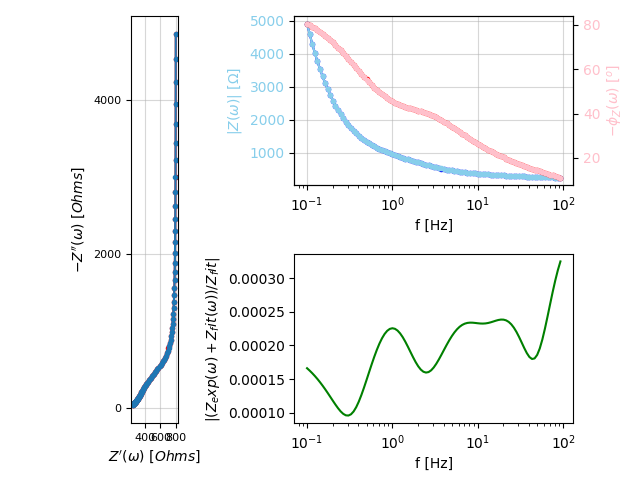

In [23]:
##-----------##
z_fit=cmodel.predict(frequencies=freq_to_fit)


#put the nyquist and the bode plot on the same figure


fig= plt.figure()
ax_nyq=fig.add_subplot(121)
ax_mag=fig.add_subplot(222)
ax_phs=ax_mag.twinx()
ax_err=fig.add_subplot(224)

#plot nyquist plot of the taken data
plot_nyquist(z_fit,ax=ax_nyq,labelsize=10,ticksize=8,color="red")

#plot bode plot of the taken data
mag_color="blue"
phs_color="red"
ax_mag.plot(freq_to_fit, np.abs(z_fit), '.-', color=mag_color)
ax_phs.plot(freq_to_fit, -np.angle(z_fit, deg=True), '.-',color=phs_color)
ax_mag.set_ylabel(r'$|Z(\omega)|$ ' +'$[{}]$'.format("Ω"), fontsize=10,color=mag_color)
ax_phs.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=10,color=phs_color)
ax_mag.set_xlabel('f [Hz]', fontsize=10)
ax_mag.set_xscale('log')
ax_mag.tick_params(axis='y', labelcolor=mag_color)
ax_phs.tick_params(axis='y', labelcolor=phs_color)
ax_mag.grid(visible=True, which='major', axis='both', alpha=.5)
fig.tight_layout()


########
##-----------##
#put the nyquist and the bode plot on the same figure

#plot nyquist plot of the taken data
plot_nyquist(zexp_to_fit,ax=ax_nyq,labelsize=10,ticksize=8)

#plot bode plot of the taken data
mag_color="SkyBlue"
phs_color="pink"
ax_mag.plot(freq_to_fit, np.abs(zexp_to_fit), '.-', color=mag_color)
ax_phs.plot(freq_to_fit, -np.angle(zexp_to_fit, deg=True), '.-',color=phs_color)
ax_mag.set_ylabel(r'$|Z(\omega)|$ ' +'$[{}]$'.format("Ω"), fontsize=10,color=mag_color)
ax_phs.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=10,color=phs_color)
ax_mag.set_xlabel('f [Hz]', fontsize=10)
ax_mag.set_xscale('log')
ax_mag.tick_params(axis='y', labelcolor=mag_color)
ax_phs.tick_params(axis='y', labelcolor=phs_color)
ax_mag.grid(visible=True, which='major', axis='both', alpha=.5)
# fig.tight_layout()


#plot the error plots
ax_err.plot(freq_to_fit,np.abs((zexp_to_fit-z_fit)/z_fit),color="green")
ax_err.set_ylabel(r'$|(Z_exp(\omega)+Z_fit(\omega))/Z_fit|$ ' , fontsize=10)
ax_err.set_xlabel('f [Hz]', fontsize=10)
ax_err.set_xscale('log')
# print(freq_to_fit)

### ---------END---------

In [27]:
# print(r'$ \omega $')

$ \omega $


In [ ]:
# from models import profile_plotter 

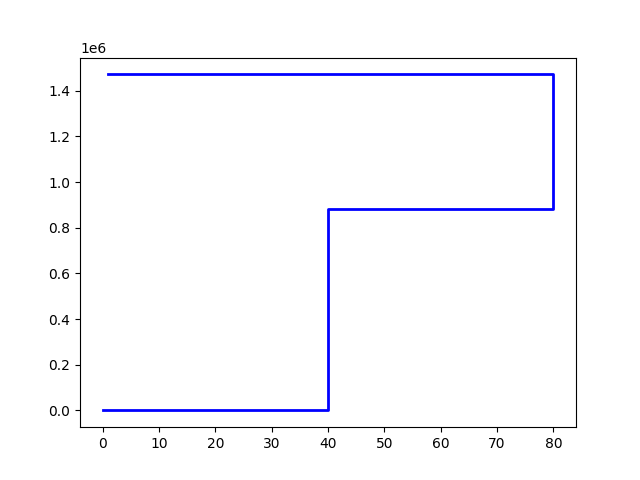

In [ ]:
# fig, ax= plt.subplots()
# # profile_plotter(circuit=c1,ax=ax)
# profile_plotter(profile="TLMthree",circuit=cmodel,ax=ax)
# circuit=cmodel
# if(circuit._is_fit()):
#         param=circuit.parameters_
# else:
#         param=circuit.initial_guess

# Rref=param[0]
# Q=param[1]
# a=param[2]
# b=param[3]

# def tau_plotter(tau,ax,name):
#     x=np.linspace(0,1,100)
#     ax.plot(x,tau(x),label=name)

# plt.show()
# # print(cthree)
# # ztwo1=c1.predict(frequencies=f)
# # zthree1=cthree.predict(frequencies=f)
# # fig, ax1 = plt.subplots()
# # models.error_plotter(f,ztwo1,zthree1,ax=ax1)

### Notes
Change the print function to directly print name of the parameters
